## Imports and read in data

!Note for this model due to limited access to HPC (the GPU queue was too long). I decided to only work on a subset of the samples. However, I have working code indicating how I would fine tune using parallel GPUs

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import os
os.chdir("/arc/project/st-jiaruid-1/linshuan/DHSs-Vector/")
from file_generate.filter_master import filter_master
import numpy as np
import torch

/arc/project/st-jiaruid-1/linshuan/conda/vector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DNABERT2 model exploration

### Load in the model

Check if internet access is available, if not load from local cache

In [2]:
import os
hostname = "huggingface.co" #example
response = os.system("ping -c 1 " + hostname)

#and then check the response...
if response == 0:
	print(f"{hostname} is up!")
	tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", 
                                    trust_remote_code=True,force_download=False)
	model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", 
									trust_remote_code=True,force_download=False)
else:
	print(f"{hostname} is down!")
	tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True,force_download=False, local_files_only=True)
	model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True,force_download=False, local_files_only=True)

sh: 1: ping: Operation not permitted


huggingface.co is down!


/scratch/st-jiaruid-1/linshuan/.cache/hugginface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that 

### Replicate the results in the DNABERT2 modle
```{Bash}
export DATA_PATH=DHSs-Vector/data/GUE
export DATA_PATH=/path/to/GUE #(e.g., /home/user)
cd DNABERT_2/finetune
# Evaluate DNABERT-2 on GUE
sh scripts/run_dnabert2.sh DATA_PATH
```

## EDA

### Taking a look at the vocab metadata

In [3]:
vocab_df = pd.read_table('data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt')

/tmp/slurm/573480/ipykernel_187649/3896072397.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vocab_df = pd.read_table('data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt')


In [4]:
vocab_df

,seqname,start,end,identifier,mean_signal,numsamples,summit,core_start,core_end,component
0,chr1,16140,16200,1.10011,0.129388,1,16170,16170.0,16170.0,Tissue invariant
1,chr1,51868,52040,1.10021,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast
2,chr1,57280,57354,1.10025,0.273251,4,57350,57350.0,57350.0,Neural
3,chr1,66370,66482,1.10027,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic
4,chr1,79100,79231,1.1003,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast
...,...,...,...,...,...,...,...,...,...,...
3591893,chrY,56882540,56882719,Y.994281,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid
3591894,chrY,56882864,56882980,Y.994286,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid
3591895,chrY,56883733,56883960,Y.994292,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast
3591896,chrY,56884440,56884580,Y.994297,0.053759,1,56884510,56884510.0,56884510.0,Lymphoid


In [5]:
print("unique components: ", len(vocab_df['component'].unique()))
print("components: ", vocab_df['component'].unique())


unique components:  16
components:  ['Tissue invariant' 'Placental / trophoblast' 'Neural'
 'Primitive / embryonic' 'Digestive' 'Lymphoid' 'Musculoskeletal'
 'Stromal B' 'Myeloid / erythroid' 'Cancer / epithelial'
 'Pulmonary devel.' 'Renal / cancer' 'Stromal A' 'Organ devel. / renal'
 'Vascular / endothelial' 'Cardiac']


In [6]:
print("max num samples asspcoated with components: ", vocab_df['numsamples'].max())
print("average num samples assocaited with components: ", vocab_df['numsamples'].mean())


max num samples asspcoated with components:  733
average num samples assocaited with components:  21.235997514406034


#### Look at the width of the DHS region

In [7]:
(vocab_df['end'] - vocab_df['start']).describe()

count    3.591898e+06
mean     2.039110e+02
std      1.028948e+02
min      2.000000e+01
25%      1.510000e+02
50%      1.960000e+02
75%      2.400000e+02
max      5.000000e+03
dtype: float64

#### Look at the confidence score

In [8]:
vocab_df['mean_signal'].describe(exclude=['count'])

count    3.591898e+06
mean     6.401372e-01
std      9.392484e-01
min      1.228750e-02
25%      2.206620e-01
50%      4.103681e-01
75%      7.617222e-01
max      4.278597e+02
Name: mean_signal, dtype: float64

### Explore the vocab metadata

In [9]:
meta_vocab = pd.read_table('data/DHS_Index_and_Vocabulary_metadata.tsv')
# loadings = np.load('data/2018-06-08NC16_NNDSVD_Basis.npy')

In [10]:
meta_vocab

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0
732,733.0,fPlacenta,Placental / trophoblast,ENCSR552XJI,ENCLB711ZZZ,ENCBS723HLT,ENCFF593AWN,AG7450,LN45076C,DS37716C,...,NaN,NaN,0.972,1380000.0,A+Sucrose,NaN,206456483.0,0.4356,115898.0,114344.0


### Now we look at the basis

In [11]:
# loadings = pd.read_table('data/DHS_Index_and_Vocabulary_metadata.tsv', header=None)
loadings = pd.read_csv('data/2018-06-08NC16_NNDSVD_Basis.csv')

In [12]:
vocab_df

,seqname,start,end,identifier,mean_signal,numsamples,summit,core_start,core_end,component
0,chr1,16140,16200,1.10011,0.129388,1,16170,16170.0,16170.0,Tissue invariant
1,chr1,51868,52040,1.10021,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast
2,chr1,57280,57354,1.10025,0.273251,4,57350,57350.0,57350.0,Neural
3,chr1,66370,66482,1.10027,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic
4,chr1,79100,79231,1.1003,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast
...,...,...,...,...,...,...,...,...,...,...
3591893,chrY,56882540,56882719,Y.994281,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid
3591894,chrY,56882864,56882980,Y.994286,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid
3591895,chrY,56883733,56883960,Y.994292,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast
3591896,chrY,56884440,56884580,Y.994297,0.053759,1,56884510,56884510.0,56884510.0,Lymphoid


### Finally look at the peaks master_dataset produced

In [13]:
peaks = pd.read_feather('data/master_dataset.ftr')

In [14]:
peaks

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fKidney_ENCLB005SRL,fKidney_ENCLB704GMQ,fKidney_ENCLB759USM,fLung_ENCLB594BSZ,fKidney_ENCLB049MNH,fUmbilical_cord_ENCLB771UER,fBone_femur_ENCLB236BWV,fLiver_ENCLB638FEH,fPlacenta_ENCLB423VBC,fPlacenta_ENCLB711ZZZ
0,chr1_16140_16200_16170,chr1,16140,16200,60,16170,1,0.129388,1,0.855153,...,0,0,0,0,0,0,0,0,0,0
1,chr1_51868_52040_51970,chr1,51868,52040,172,51970,1,0.080034,7,0.973545,...,0,0,0,0,0,0,0,0,0,0
2,chr1_57280_57354_57350,chr1,57280,57354,74,57350,4,1.093002,8,1.000000,...,0,0,0,0,0,0,0,0,0,0
3,chr1_66370_66482_66430,chr1,66370,66482,112,66430,8,1.469725,3,0.332213,...,0,0,0,0,0,0,0,0,0,0
4,chr1_79100_79231_79150,chr1,79100,79231,131,79150,2,0.226098,7,0.501840,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591893,chrY_56882540_56882719_56882610,chrY,56882540,56882719,179,56882610,1,0.038079,5,0.803229,...,0,0,0,0,0,0,0,0,0,0
3591894,chrY_56882864_56882980_56882930,chrY,56882864,56882980,116,56882930,1,0.115489,5,0.742349,...,0,0,0,0,0,0,0,0,0,0
3591895,chrY_56883733_56883960_56883830,chrY,56883733,56883960,227,56883830,5,2.456885,7,0.559734,...,0,0,0,0,0,0,0,0,0,0
3591896,chrY_56884440_56884580_56884510,chrY,56884440,56884580,140,56884510,1,0.053759,5,0.803229,...,0,0,0,0,0,0,0,0,0,0


## Data preprocessing

We want to first experiment on "easy" peaks (also because lack of computing power and no HPC). As such we will work on only a subset of samples as a proof of concept.
We argue that this is an "easier" problem for the model and it should probably work better

1. First work on top 75% peaks with the highest component proportion
2. Bio samples with vocabulary representative component (not the tissue invariant ones)
3. Look at Renal and epithelial cells specifically since they seem to have both disease and normal tissues
4. Randomly sampel only 20,000 DHS

In [15]:
meta_vocab

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0
732,733.0,fPlacenta,Placental / trophoblast,ENCSR552XJI,ENCLB711ZZZ,ENCBS723HLT,ENCFF593AWN,AG7450,LN45076C,DS37716C,...,NaN,NaN,0.972,1380000.0,A+Sucrose,NaN,206456483.0,0.4356,115898.0,114344.0


In [53]:
# rep_lib = meta_vocab[(meta_vocab['Vocabulary representative'].notna()) & (meta_vocab['Vocabulary representative'] != "Tissue invariant") & ((meta_vocab['System'] == "Renal") | (meta_vocab['System'] == "Epithelial"))
#                      & (meta_vocab['DCC SPOT score'] > meta_vocab['DCC SPOT score'].describe()['50%'])]
rep_lib = meta_vocab[(meta_vocab['Vocabulary representative'].notna()) &  ((meta_vocab['System'] == "Renal") | (meta_vocab['System'] == "Epithelial"))
                     & (meta_vocab['DCC SPOT score'] > meta_vocab['DCC SPOT score'].describe()['50%'])]
rep_lib_id = rep_lib['Biosample name'] + "_" + rep_lib['DCC Library ID']

In [17]:
peaks['proportion'].describe().loc['25%']

0.45994189828590715

In [57]:
filtered_peaks = peaks[(peaks['proportion'] > 0.5) & (peaks[rep_lib_id.tolist()].any(axis=1)) & (peaks['chr'] !='chrX')]

In [58]:
filtered_peaks['DHS_width'].describe()

count    417592.000000
mean        212.043404
std          89.750163
min          20.000000
25%         171.000000
50%         200.000000
75%         237.000000
max        2760.000000
Name: DHS_width, dtype: float64

### Check the most frequent components

In [70]:
filtered_peaks['component'].value_counts()

component
10    92582
4     81951
6     58808
16    58699
3     45272
7     18719
8     14451
13     9336
5      6790
12     6237
14     5894
9      5622
15     5524
11     5257
1      1548
2       902
Name: count, dtype: int64

### Remove components that are not representative so far

In [71]:
filtered_peaks = filtered_peaks[filtered_peaks['component'].isin(filtered_peaks['component'].value_counts().index[filtered_peaks['component'].value_counts() > 10000].tolist())]

In [75]:
filtered_peaks['component'].value_counts()

component
5    92582
1    81951
2    58808
6    58699
0    45272
3    18719
4    14451
Name: count, dtype: int64

### Map components to {0 ... k} for classification

In [73]:

mapping = {label: i for i, label in enumerate(sorted(set(filtered_peaks['component'].value_counts().index)))}
reverse_mapping = {new: original for original, new in mapping.items()}

In [74]:
filtered_peaks['component'] = filtered_peaks['component'].map(mapping)

### Randomly sample

In [20]:
filtered_peaks = filtered_peaks.sample(n=20000, replace=False, random_state=43)

### Store the data for fine-tuning

In [76]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(filtered_peaks[["sequence", "component"]], test_size=0.2, random_state=42, shuffle=True)
train, val = train_test_split(train, test_size=0.2, random_state=42,shuffle=True)

In [77]:
train.to_csv("/scratch/st-jiaruid-1/linshuan/slurm/vector/data/train.csv", index=False)
val.to_csv("/scratch/st-jiaruid-1/linshuan/slurm/vector/data/dev.csv", index=False)
test.to_csv("/scratch/st-jiaruid-1/linshuan/slurm/vector/data/test.csv", index=False)

# train.to_csv("data/train.csv", index=False)
# val.to_csv("data/dev.csv", index=False)
# test.to_csv("data/test.csv", index=False)

**Run fine tune here**

In [24]:
model = model.to('cuda')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
  

In [79]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Mon Feb 19 18:06:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V

### Obtain embeddings from model

In [78]:
tokens = tokenizer(filtered_peaks['sequence'].tolist(), padding=True, truncation=True, return_tensors="pt").to('cuda')

### Utilizing garbarge collector to get around the problem of cuda out of memory

In [43]:
import gc
stride = 300
embeddings_all = None
start = 0
end = 0
with torch.no_grad():
	while end < tokens['input_ids'].shape[0]:
		end = min(end+stride, tokens['input_ids'].shape[0]+1)
		print("working on ", start, " to ", end)
		embeddings = model(tokens['input_ids'][start:end], tokens['attention_mask'][start:end])[0]
		if start == 0:
			embeddings_all = torch.mean(embeddings, axis=1).to('cpu').detach()
		else:
			embeddings_all = torch.cat((embeddings_all, torch.mean(embeddings, axis=1).to('cpu').detach()), 0)
		start = end
		del embeddings
		torch.cuda.empty_cache() 
		gc.collect()  # call the garbage collector


working on  0  to  300
working on  300  to  600
working on  600  to  900
working on  900  to  1200
working on  1200  to  1500
working on  1500  to  1800
working on  1800  to  2100
working on  2100  to  2400
working on  2400  to  2700
working on  2700  to  3000
working on  3000  to  3300
working on  3300  to  3600
working on  3600  to  3900
working on  3900  to  4200
working on  4200  to  4500
working on  4500  to  4800
working on  4800  to  5100
working on  5100  to  5400
working on  5400  to  5700
working on  5700  to  6000
working on  6000  to  6300
working on  6300  to  6600
working on  6600  to  6900
working on  6900  to  7200
working on  7200  to  7500
working on  7500  to  7800
working on  7800  to  8100
working on  8100  to  8400
working on  8400  to  8700
working on  8700  to  9000
working on  9000  to  9300
working on  9300  to  9600
working on  9600  to  9900
working on  9900  to  10200
working on  10200  to  10500
working on  10500  to  10800
working on  10800  to  11100
wor

In [45]:
embeddings_all.shape

torch.Size([19800, 768])

### Visualize pooled embeddings of the model

<Axes: >

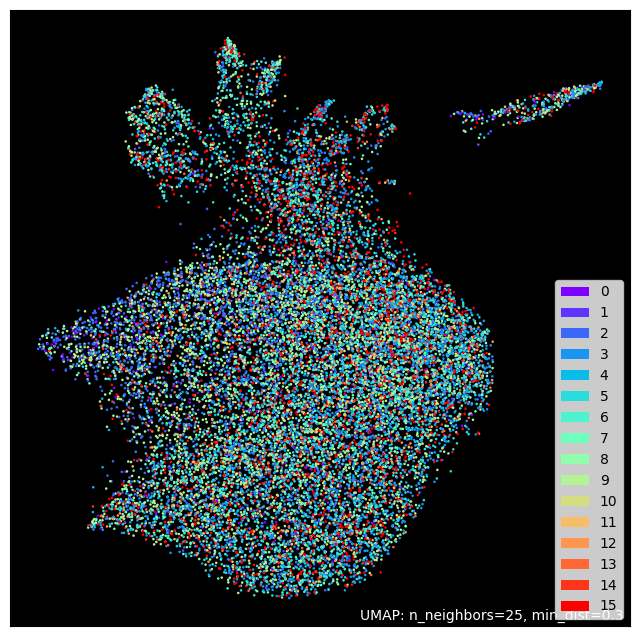

In [47]:
import umap
import umap.plot
mapper = umap.UMAP(n_neighbors=25, min_dist=0.1, n_components=2).fit(embeddings_all)
umap.plot.points(mapper, labels=filtered_peaks['component'][:19800], theme='fire')